In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy
from sklearn.model_selection import KFold


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [4]:
def norm(x, *par):
    return par[0]*np.exp(par[1]*x**2)

In [5]:
def poly(x, *par):
    return np.polyval(par,x)

In [6]:
def log(x, *par):
    return par[0]*np.log(x)

In [7]:
def const(x, *par):
    return -10

In [8]:
def recip(x, *par):
    return 1/(par[0]*x**2+1)

In [9]:
def gp(x_train, y_train, kernel, mean_function, init_params):
    res = scipy.optimize.curve_fit(
        mean_function,  np.ravel(x_train), np.ravel(y_train), p0=init_params, maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_function(x, *par)
    mf.update_gradients = lambda a,b: None
    
    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()
    return model

In [10]:
def draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, subplot, ylim=False):
    subplot.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    subplot.scatter(x_train, y_train, marker="x", color='black', label="train")
    subplot.scatter(x_val, y_val, marker="x", color='red', label="validate")
    subplot.scatter(x_test, y_test, marker="x", color='blue', label="test")
    subplot.plot(domain, y_mean, label="mean")
    if ylim:
        subplot.set_ylim(ylim)       
    subplot.grid(True)
    subplot.legend()


In [11]:
def cwgp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    model_holder = kwargs["model_holder"]
    ylim = kwargs["ylim"]
    
    cwgp_y_train = y_train
    cwgp_y_val = y_val
    cwgp_y_test = y_test
    
    for cwgp_model in model_holder:
        cwgp_y_train, y_d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_train)
        
        cwgp_y_val, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_val)
        
        cwgp_y_test, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_test)
        
    model = gp(x_train, cwgp_y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )

    start, end = 1840, 2200
    domain_discrete = np.arange(start, end+1).reshape(-1,1)
    domain = np.linspace(start,end,end-start+1)
    cwgp_y_all = model.predict(domain_discrete)
    cwgp_y_mean, cwgp_y_var = cwgp_y_all[0], cwgp_y_all[1]
    cwgp_y_top, cwgp_y_bot = cwgp_y_mean + 1.96*np.sqrt(cwgp_y_var), cwgp_y_mean - 1.96*np.sqrt(cwgp_y_var)
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    
    y_mean, y_var, y_top, y_bot = cwgp_y_mean, cwgp_y_var, cwgp_y_top, cwgp_y_bot
    
    for cwgp_model in model_holder[::-1]:
        y_mean, y_var = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_var)
        y_top, y_bot = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_top), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_bot)
        predict_y_val_mean, predict_y_test_mean = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_val_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_test_mean)
        
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
        
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
    
    draw(domain, cwgp_y_mean, cwgp_y_top, cwgp_y_bot, x_train, cwgp_y_train, x_val, 
         cwgp_y_val, x_test, cwgp_y_test, ax1)
    draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, ax2, ylim=ylim)

    print(kwargs["hyperparams"])
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    plt.show()

In [12]:
def gp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    ylim = kwargs["ylim"]
    
    model = gp(x_train, y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )
    
    start, end = 1940, 2031
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    
    model.plot(plot_limits=[start,end])
    plt.ylim(ylim)
    plt.grid(True)
    plt.scatter(x_train, y_train, marker="x", color='black', label="train")
    plt.scatter(x_val, y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.show()
    

In [13]:
CSV_FIlE = "../japan.csv"
df = pd.read_csv(CSV_FIlE)
age = 50
age_lim = [0,0.02]
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["total"].to_numpy().reshape(-1,1)


In [14]:
test_ratio = 1 - 0.15
length = len(rate)

test = int(test_ratio*length)

x_tv, y_tv = year[:test], rate[:test]
x_test, y_test = year[test:], rate[test:]

params:[-1.36418903e-04  2.74791906e-01]
validate_rmse: 0.0003567705979384793 
 test_rmse: 0.00028425253399073794



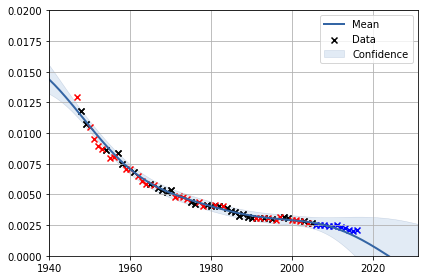

params:[-1.34488288e-04  2.71083079e-01]
validate_rmse: 0.00021459270477095288 
 test_rmse: 0.0011232161656151377



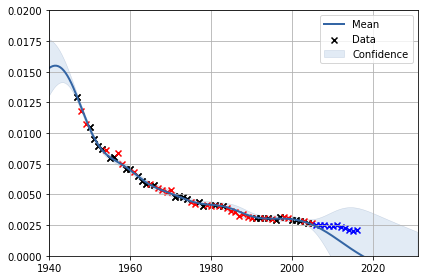

In [15]:
kf = KFold(n_splits=2, random_state=42, shuffle=True)

for train, val in kf.split(x_tv):
    x_train, y_train, x_val, y_val = x_tv[train], y_tv[train], x_tv[val], y_tv[val]
    result = gp_regression(
                         x_train=x_train,y_train=y_train,
                         x_val=x_val,y_val=y_val,
                         x_test=x_test,y_test=y_test,ylim=age_lim,
                         mean_func=poly, init_params=(1,-0.001),
                         kernel = GPy.kern.RBF(1),)

params:[-5.73197038e-05  1.17486047e-01]
validate_rmse: 0.002752015516690308 
 test_rmse: 0.00015688837043934973



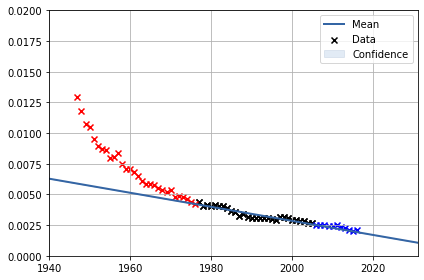

params:[-2.51119914e-04  4.99705777e-01]
validate_rmse: 0.003908527637345132 
 test_rmse: 0.007679791516684874



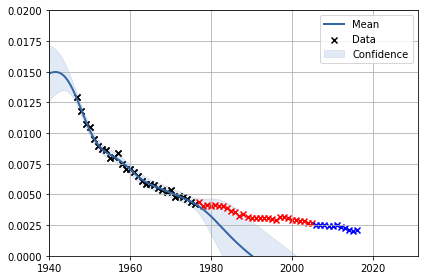

In [16]:
kf = KFold(n_splits=2)

for train, val in kf.split(x_tv):
    x_train, y_train, x_val, y_val = x_tv[train], y_tv[train], x_tv[val], y_tv[val]
    result = gp_regression(
                         x_train=x_train,y_train=y_train,
                         x_val=x_val,y_val=y_val,
                         x_test=x_test,y_test=y_test,ylim=age_lim,
                         mean_func=poly, init_params=(1,-0.001),
                         kernel = GPy.kern.RBF(1),)

  0%|          | 0/16 [00:00<?, ?it/s]

[('box_cox', 1), ('sa', 1)]
params:[-1.08907194e-02  1.49007752e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.00030802568597150775 
 test_rmse: 0.0003243010856940319



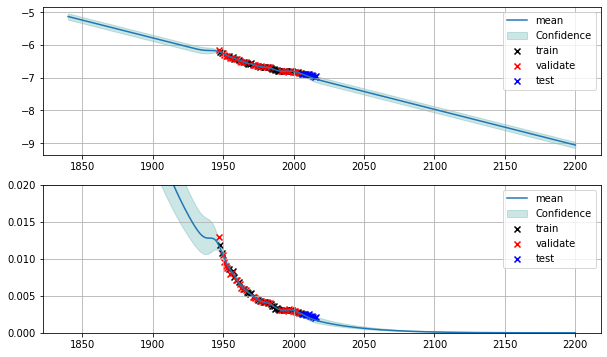

params:[-1.07565804e-02  1.46319607e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.00020580814713121602 
 test_rmse: 0.0003214209484934627



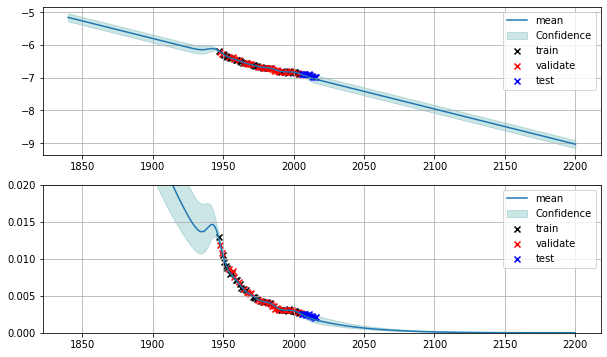

  6%|▋         | 1/16 [00:01<00:17,  1.20s/it]

params:[-7.71781677e-02  1.51710500e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.00034545980592063784 
 test_rmse: 0.00013540729739383735



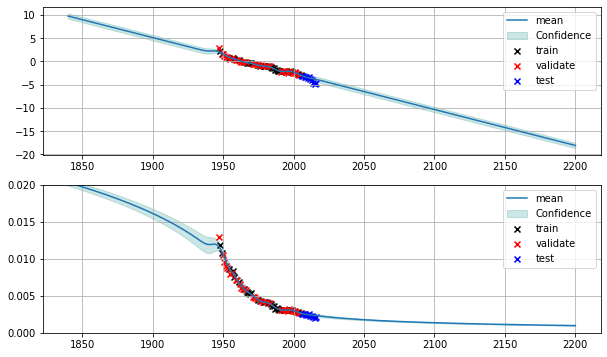

params:[-7.19315555e-02  1.41264084e+02]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.0002183413990622126 
 test_rmse: 0.00014452961842911354



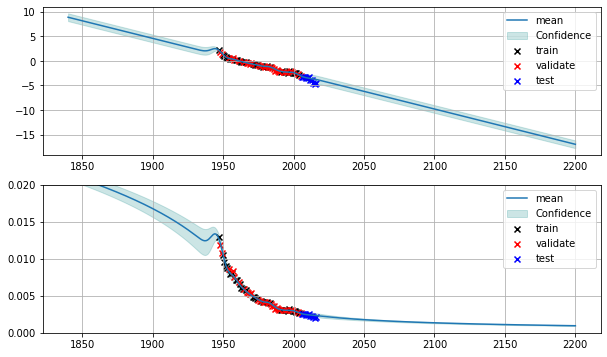

 12%|█▎        | 2/16 [00:02<00:16,  1.19s/it]

params:[-7.47116001e-02  1.46040849e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.00036193455989238176 
 test_rmse: 0.00021407153817869738



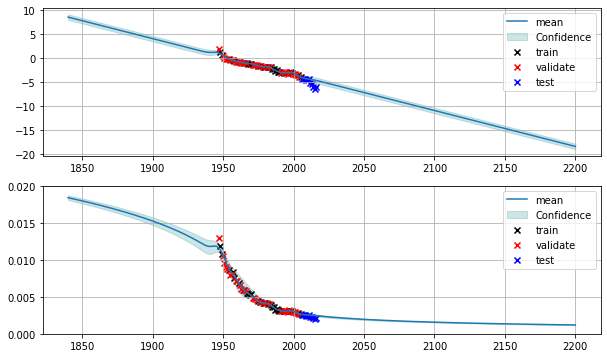

params:[-7.11947973e-02  1.38835829e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.00021996774421837687 
 test_rmse: 0.00015612930029727446



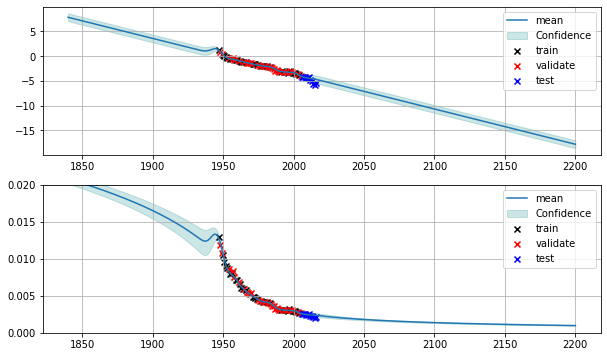

 19%|█▉        | 3/16 [00:03<00:14,  1.11s/it]

params:[-7.72028721e-02  1.51744770e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.00034599785799208706 
 test_rmse: 0.0001315031309306738



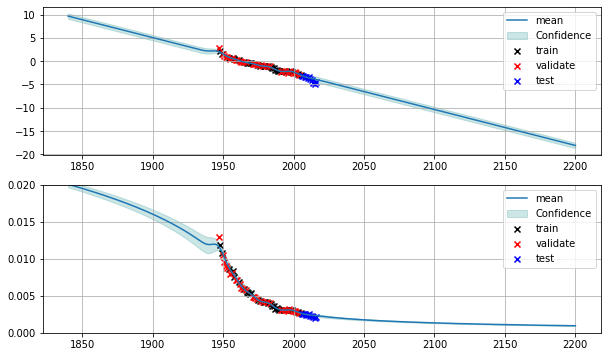

params:[-7.18835584e-02  1.41153296e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.00021914785868239547 
 test_rmse: 0.00014076197790656694



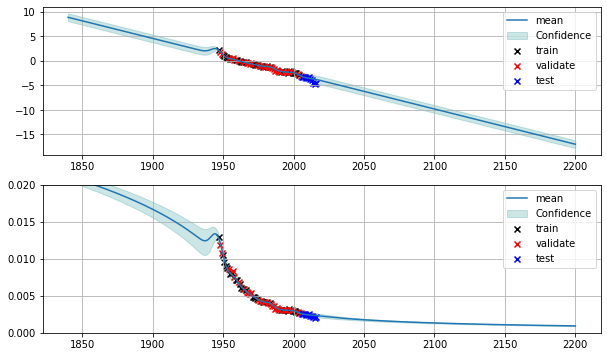

 25%|██▌       | 4/16 [00:04<00:14,  1.18s/it]

params:[-7.58661758e-02  1.47370613e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.0003783278029830994 
 test_rmse: 0.000233293394711848



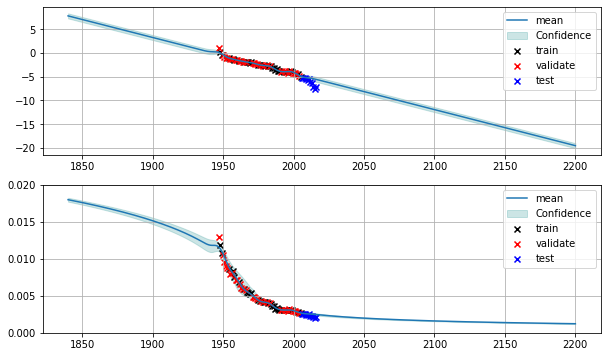

params:[-7.19850023e-02  1.39446030e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.00022399917099171133 
 test_rmse: 0.00017634439873357336



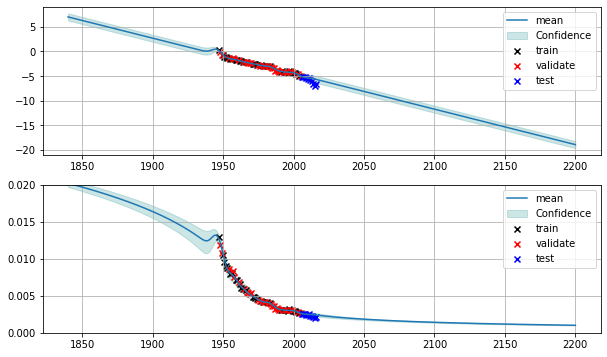

 31%|███▏      | 5/16 [00:05<00:12,  1.18s/it]

params:[-6.77537177e-02  1.32796082e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.000379840520872304 
 test_rmse: 0.00016816745002313875



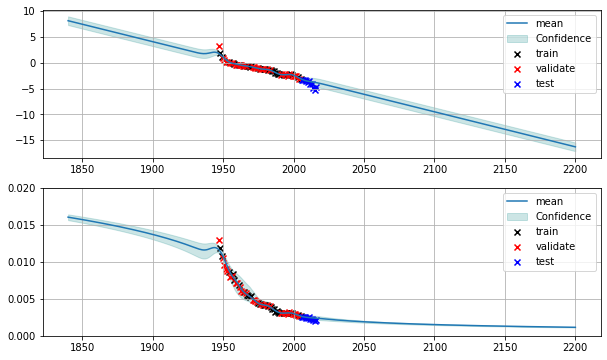

params:[-6.37590846e-02  1.24634374e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.00022989877226624482 
 test_rmse: 0.00013728141277793139



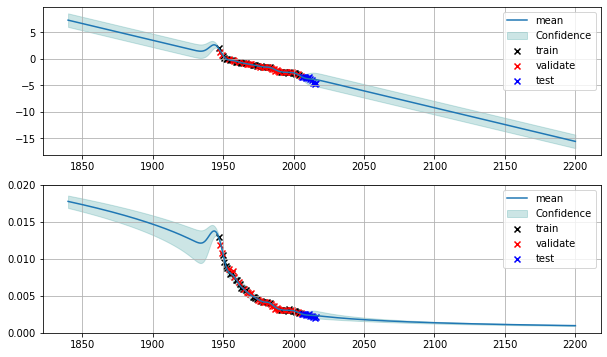

 38%|███▊      | 6/16 [00:06<00:11,  1.15s/it]

params:[-7.48368828e-02  1.46273401e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.0003634673073533689 
 test_rmse: 0.0002108706465378695



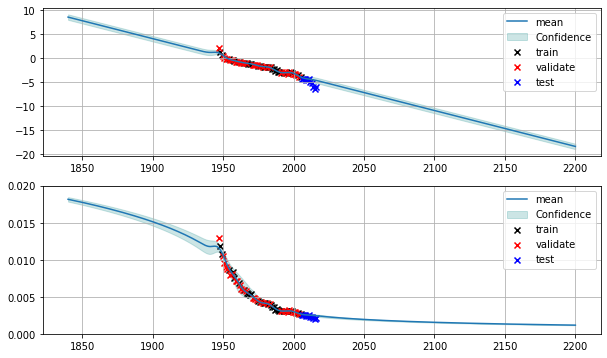

params:[-7.08446312e-02  1.38146308e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.00022158043718125404 
 test_rmse: 0.00015961252377985342



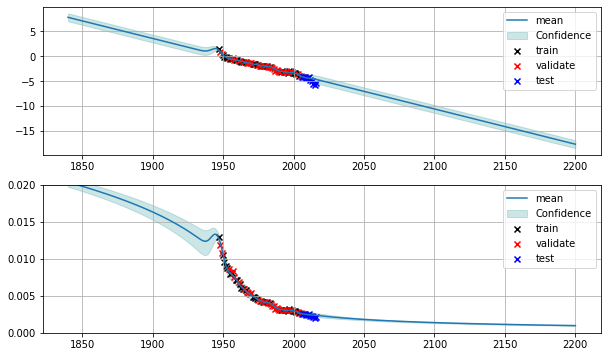

 44%|████▍     | 7/16 [00:08<00:10,  1.17s/it]

params:[-7.72271389e-02  1.51774854e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.00034667334692628217 
 test_rmse: 0.00012680647309534066



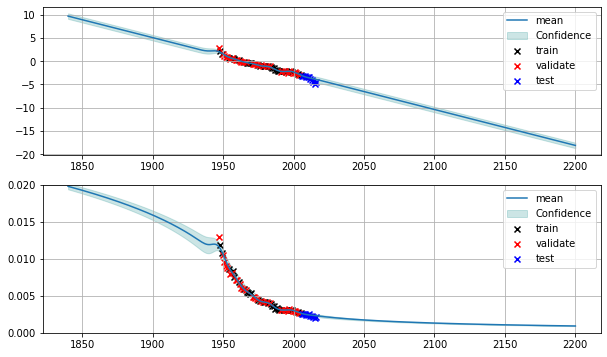

params:[-7.18188311e-02  1.41005743e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.00022014063173390986 
 test_rmse: 0.00013628329538589547



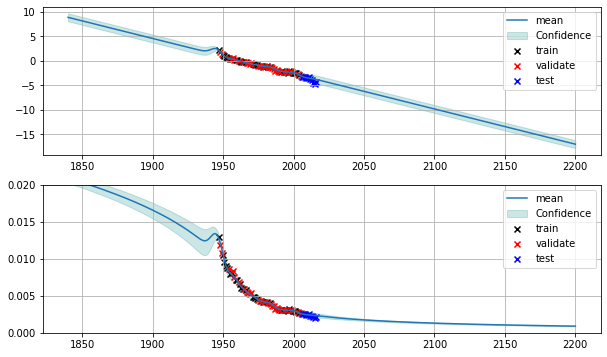

 50%|█████     | 8/16 [00:09<00:09,  1.18s/it]

params:[-7.39639423e-02  1.42014037e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.00045386635556843123 
 test_rmse: 0.00012051547430785086



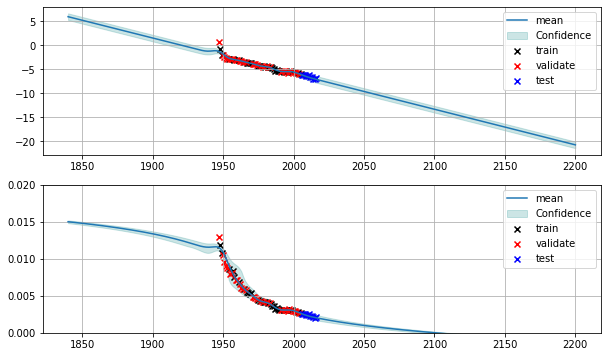

params:[-6.75896770e-02  1.29265989e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.0002793565254192273 
 test_rmse: 0.00020019999005673332



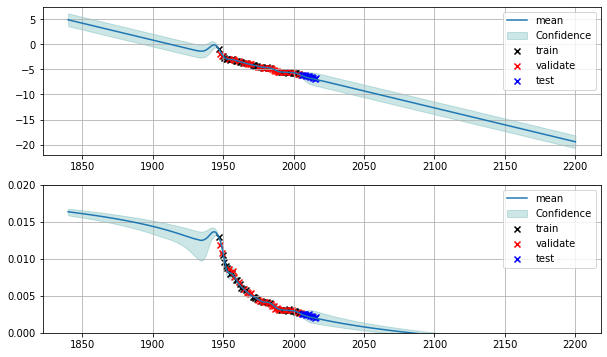

 56%|█████▋    | 9/16 [00:10<00:07,  1.14s/it]

params:[-6.64591425e-02  1.29826525e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.0005908466000268015 
 test_rmse: 8.644838442060507e-05



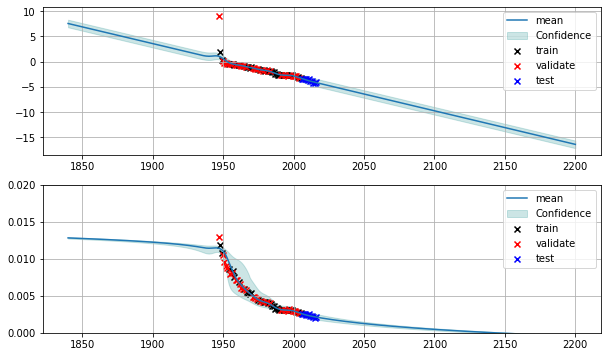

params:[-6.07575137e-02  1.18338341e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.0003265180279715355 
 test_rmse: 0.0001362027651438581



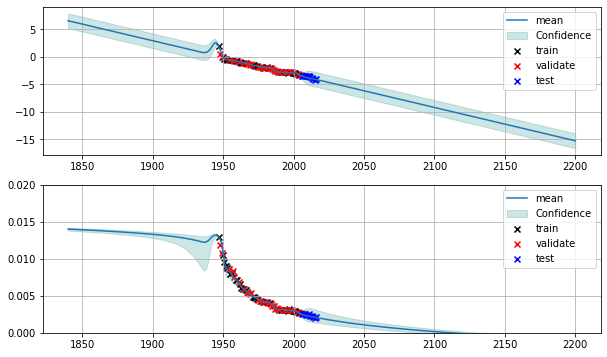

 62%|██████▎   | 10/16 [00:11<00:06,  1.10s/it]

params:[-7.52726490e-02  1.46602743e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.0006900200288407432 
 test_rmse: 0.00011763601340324524



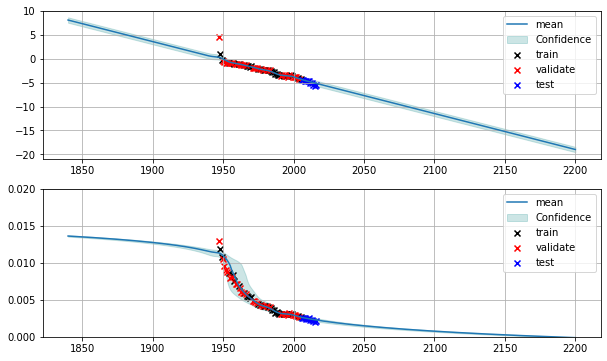

params:[-6.87394066e-02  1.33371406e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.0002773673718250614 
 test_rmse: 8.131837380518298e-05



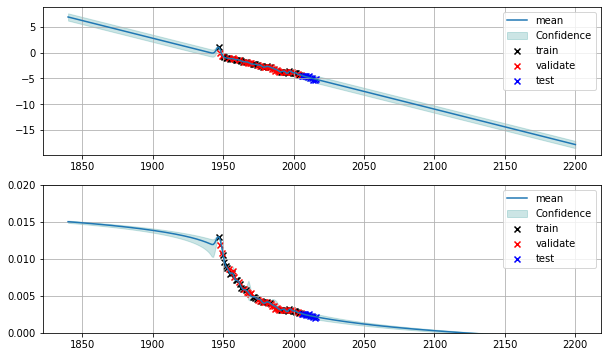

 69%|██████▉   | 11/16 [00:12<00:05,  1.13s/it]

params:[-7.04252679e-02  1.37728138e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.00046939946265110933 
 test_rmse: 0.00012470111170454488



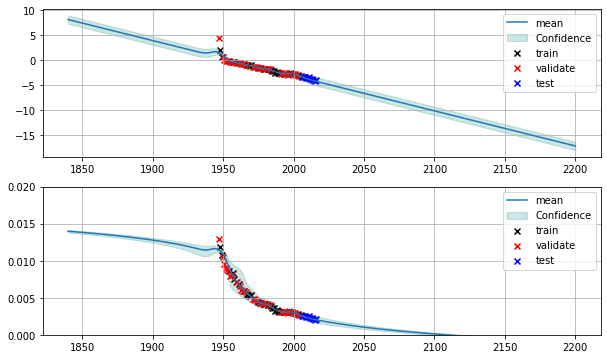

params:[-6.32260092e-02  1.23246621e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.0002604791978744964 
 test_rmse: 0.0002425642231393638



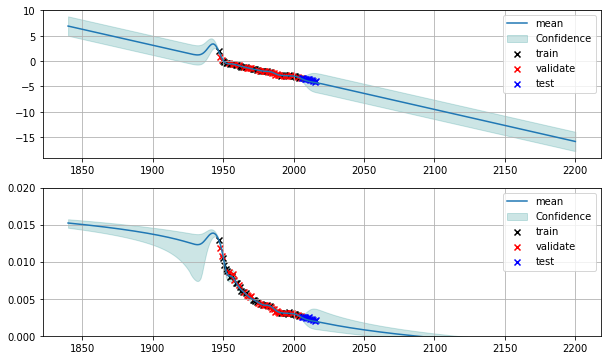

 75%|███████▌  | 12/16 [00:13<00:04,  1.11s/it]

params:[-8.25458506e-02  1.60047083e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.00041414657132176285 
 test_rmse: 8.488521853361495e-05



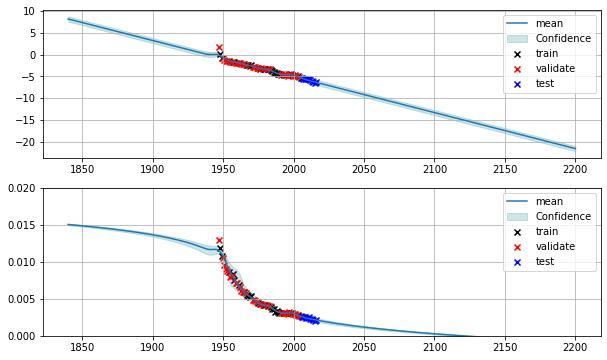

params:[-7.50531425e-02  1.45056575e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 0.0002639711834608894 
 test_rmse: 0.00013966258179820814



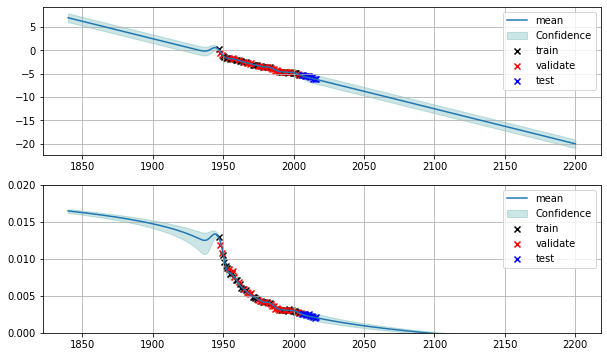

 81%|████████▏ | 13/16 [00:14<00:03,  1.09s/it]

params:[-7.04253862e-02  1.37728357e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.0004693945923227155 
 test_rmse: 0.00012470957085722578



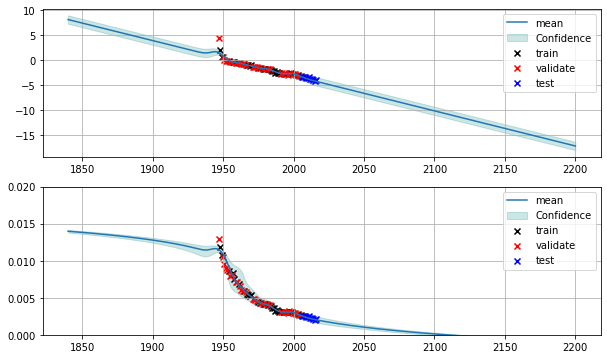

params:[-6.32262814e-02  1.23247201e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 0.00026048609984596536 
 test_rmse: 0.00024253493648328312



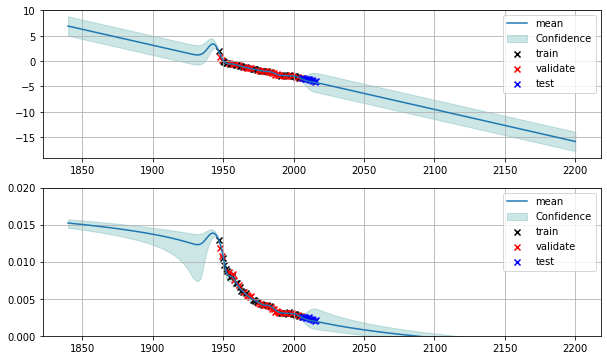

 88%|████████▊ | 14/16 [00:16<00:02,  1.16s/it]

params:[-8.13235076e-02  1.58602220e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.0004077348944017383 
 test_rmse: 9.33237341229094e-05



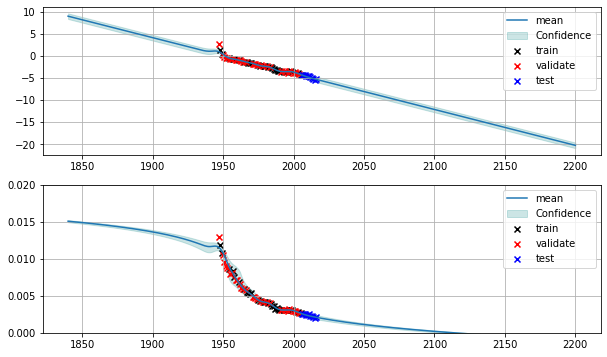

params:[-7.22647609e-02  1.40497986e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 0.0002508972443155227 
 test_rmse: 0.00017724407726934732



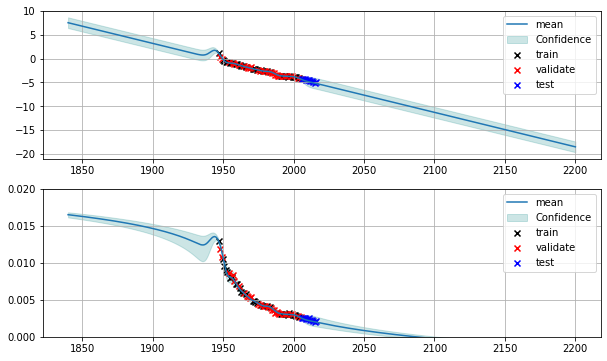

 94%|█████████▍| 15/16 [00:17<00:01,  1.15s/it]

params:[-7.84367268e-02  1.53638795e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.0003644199884670048 
 test_rmse: 0.000264970170316011



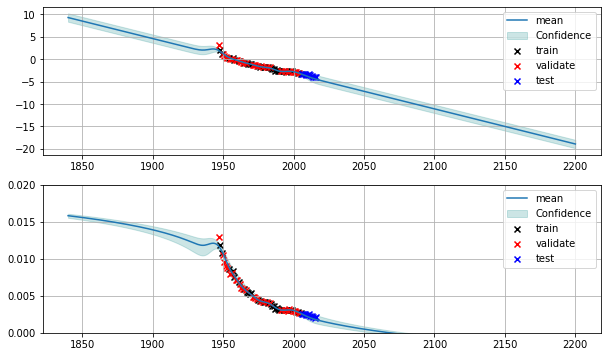

params:[-7.07094302e-02  1.38252286e+02]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 0.00023823959249334817 
 test_rmse: 0.00031753478155054527



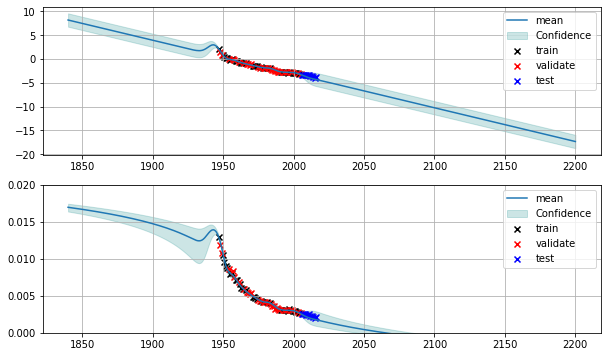

100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


In [17]:
result = grid_search(cwgp_regression, x_tv, y_tv, {"c":4,"n":[1],"transformations":["box_cox","sa"]},
                    cv=True, n_splits=2, shuffle=True,
                     x_test=x_test,y_test=y_test,ylim=age_lim,
                     mean_func=poly, init_params=(1,-0.1),
                     kernel = GPy.kern.RBF(1),
                    )